<a href="https://colab.research.google.com/github/eddyCabrera98/PosterSP1/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, AveragePooling2D, Input, Flatten
import os, datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL.Image as Image
import numpy as np
import matplotlib.pylab as plt
import shutil
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib as mt
from pylab import MaxNLocator
from sklearn import preprocessing
import math
from scipy.interpolate import make_interp_spline, BSpline

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [0]:
 font = {'family' : 'monospace',
          'weight': 'normal',
          'size'   : 15}
  mt.rc('font', **font)

#Handle Data

## Loading images Locally

In [0]:
## Credentials
os.environ['KAGGLE_USERNAME'] = "eddyalexander"
os.environ['KAGGLE_KEY'] = "925fe34eec7488f6e73930d09751b9d4"

In [3]:
## Kaggle Dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria 

 99% 669M/675M [00:11<00:00, 65.8MB/s]
100% 675M/675M [00:11<00:00, 61.0MB/s]


In [0]:
# Unzip
!unzip -q "cell-images-for-detecting-malaria.zip"

In [0]:
# Set up Paths
path = 'dataset/' #Here we will store the images for training
#after unzipping images we are left with this structure
path_images = "/content/cell_images/" 
path_sick = "/content/cell_images/Parasitized" 
path_healthy = "/content/cell_images/Uninfected"
#Train, validation and test directories inside dataset directory
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
test_dir = os.path.join(path, 'test')
#Create a Parasitized and uninfected directory for each dataset partiticion
train_sick_dir = os.path.join(train_dir, 'Parasitized')  
train_healthy_dir = os.path.join(train_dir, 'Uninfected')  
validation_sick_dir = os.path.join(validation_dir, 'Parasitized') 
validation_healthy_dir = os.path.join(validation_dir, 'Uninfected')
test_sick_dir = os.path.join(test_dir, 'Parasitized') 
test_healthy_dir = os.path.join(test_dir, 'Uninfected')  
if os.path.exists(path):
  shutil.rmtree(path)
os.makedirs(train_sick_dir)
os.makedirs(train_healthy_dir)
os.makedirs(validation_sick_dir)    
os.makedirs(validation_healthy_dir)
os.makedirs(test_sick_dir)    
os.makedirs(test_healthy_dir)

In [6]:
train_sick_dir

'dataset/train/Parasitized'

## Splitting Dataset

In [0]:
#This method will grab a src folder destination, and divide in test train validation folders
#In this proportion
# 0.1 from original will become part of test folder
# 0.2 of what is left, after removing test images will become part of validation folder
# 0.8 of what is left after removing test images will become part of train folder
def manage_images(src, dest_train, dest_test, dest_val, val_split = 0.2, test_split=0.1):
  total = len(os.listdir(src))
  test = np.int(total*test_split)
  val = np.int(total*(1-test_split)*val_split)
  print("Total Images:{} Test Images:{} Validation Images:{}".format(total, test, val))
  files = os.listdir(src)
  count=0
  for file_name in files:
    try:
      dest = dest_train if (count >= (val+test)) else dest_val if (count >= test) else dest_test
      dest_file = os.path.join(dest,file_name) 
      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return

In [8]:
#Dividing Dataset into directores
manage_images(path_healthy, train_healthy_dir,test_healthy_dir , validation_healthy_dir)
manage_images(path_sick, train_sick_dir,test_sick_dir , validation_sick_dir)

Total Images:13780 Test Images:1378 Validation Images:2480
Invalid image:  Thumbs.db cannot identify image file '/content/cell_images/Uninfected/Thumbs.db'
Total Images:13780 Test Images:1378 Validation Images:2480
Invalid image:  Thumbs.db cannot identify image file '/content/cell_images/Parasitized/Thumbs.db'


In [9]:
#Length of each directory
train_sick = len(os.listdir(train_sick_dir))
train_healthy = len(os.listdir(train_healthy_dir))
test_sick = len(os.listdir(test_sick_dir))
test_healthy = len(os.listdir(test_healthy_dir))
val_sick = len(os.listdir(validation_sick_dir))
val_healthy = len(os.listdir(validation_healthy_dir))
train_sick, train_healthy, test_sick, test_healthy, val_sick, val_healthy

(9921, 9921, 1378, 1378, 2480, 2480)

# Stats and Graphs Tools

In [0]:
##Graph validation accuracy and loss, saves plot to filename, see examples in Convnet
def stats(history, epochs, filename):
  #Graphs default
  font = {'family' : 'monospace',
          'weight': 'normal',
          'size'   : 15}
  mt.rc('font', **font)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epoch = np.arange(epochs)

  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(18.5, 8)
  plt.subplots_adjust(hspace=0.5)
  ax1.plot(epoch, acc, label='Training Accuracy')
  ax1.plot(epoch, val_acc, label='Validation Accuracy')
  ax1.legend(loc='lower right')
  ax1.set_title('Training and Validation Accuracy')
  ax1.set_xlabel('epoch')
  xa = ax1.get_xaxis()
  xa.set_major_locator(MaxNLocator(integer=True))
  ax2.plot(epoch, loss, label='Training Loss')
  ax2.plot(epoch, val_loss, label='Validation Loss')
  ax2.legend(loc='upper right')
  ax2.set_title('Training and Validation Loss')
  ax2.set_xlabel('epoch')
  xa = ax2.get_xaxis()
  xa.set_major_locator(MaxNLocator(integer=True))
  plt.savefig(filename)
  plt.show()

In [0]:
# Returns predictions
def predict_classes(model, generator, steps):
  proba = model.predict(generator, workers=0, verbose=1, steps=steps)
  if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
  else:
        return (proba > 0.5).astype('int32')

In [0]:
# Returns confusion matrix, prints Accuracy, precision, Recall and F1 Score
def test_stats(test_datagen, model, steps):
  test_datagen.reset()
  yhat_classes = predict_classes(model, test_datagen, steps)
  yhat_classes = yhat_classes[:, 0]
  print(len(yhat_classes))
  testY = test_datagen.labels[0:len(yhat_classes)]
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(testY, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(testY, yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(testY, yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(testY, yhat_classes)
  print('F1 score: %f' % f1)
  #Confusion Matrix
  matrix = confusion_matrix(testY, yhat_classes)
  return (matrix)

In [0]:
## Builds both confusion Matrix and normalized confusion matrix, saves plots to filename
def confusionMatrix(matrix, filename): 
  df_cm = pd.DataFrame(matrix, columns=np.array([0, 1]), index = np.array([0, 1]))
  plt.figure(figsize = (10,7))
  plt.subplots_adjust(hspace=0.5)
  fig, (ax, ax1) = plt.subplots(1, 2)
  fig.set_figheight(7)
  fig.set_figwidth(20)
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20},fmt=".1f", ax=ax, xticklabels = ["Uninfected", "Parasitized"] , yticklabels = ["Uninfected", "Parasitized"])#
  n_df = [[df_cm[0][0]/(df_cm[0][0]+ df_cm[1][0]), df_cm[1][0]/(df_cm[0][0]+ df_cm[1][0])],[df_cm[0][1]/(df_cm[0][1]+ df_cm[1][1]), df_cm[1][1]/(df_cm[0][1]+ df_cm[1][1])]]
  sns.heatmap(n_df, cmap="Blues", annot=True,annot_kws={"size": 20},fmt=".2f", ax=ax1, xticklabels = ["Uninfected", "Parasitized"], yticklabels =  ["Uninfected", "Parasitized"] )
  ax1.set_title('Normalized Confusion Matrix', fontsize=25)
  ax1.set_ylabel("Observations")
  ax1.set_xlabel("Predictions")
  ax.set_title('Confusion Matrix', fontsize=25)
  ax.set_ylabel("Observations")
  ax.set_xlabel("Predictions")
  plt.savefig(filename)
  sns.reset_orig()
  font = {'family' : 'monospace',
          'weight': 'normal',
          'size'   : 15}
  mt.rc('font', **font)

In [0]:
#normalized = True, if matrix needs to be normalized, save to filename
def confusionMatrix_separated(matrix, filename, normalized): 
  df_cm = pd.DataFrame(matrix, columns=np.array([0, 1]), index = np.array([0, 1]))
  fig, ax = plt.subplots(1, figsize = (10,7))
  sns.set(font_scale=1.4)#for label size
  if (normalized):
    n_df = [[df_cm[0][0]/(df_cm[0][0]+ df_cm[1][0]), df_cm[1][0]/(df_cm[0][0]+ df_cm[1][0])],[df_cm[0][1]/(df_cm[0][1]+ df_cm[1][1]), df_cm[1][1]/(df_cm[0][1]+ df_cm[1][1])]]
    sns.heatmap(n_df, cmap="Blues", annot=True,annot_kws={"size": 20},fmt=".2f", ax=ax, xticklabels = ["Uninfected", "Parasitized"], yticklabels =  ["Uninfected", "Parasitized"] )
    ax.set_title('Normalized Confusion Matrix', fontsize=25)
  else:
    ax.set_title('Confusion Matrix', fontsize=25)
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20},fmt=".1f", ax=ax, xticklabels = ["Uninfected", "Parasitized"] , yticklabels = ["Uninfected", "Parasitized"])#  
  ax.set_ylabel("Observations")
  ax.set_xlabel("Predictions")
  plt.savefig(filename)
  sns.reset_orig()
  font = {'family' : 'monospace',
          'weight': 'normal',
          'size'   : 15}
  mt.rc('font', **font)

In [0]:
def smoothing(train, validation, epoch, ylabel, ylimit, filename, title, label_train, label_val, loc):
  font = {'family' : 'monospace',
          'weight': 'normal',
          'size'   : 15}
  mt.rc('font', **font)
  plt.figure(figsize=(10, 8))
  ax = plt.gca()
  xnew1 = np.linspace(epoch.min(),epoch.max(),300)
  xnew2 = np.linspace(epoch.min(),epoch.max(),300)
  spl_train = make_interp_spline(epoch, train, k=2) #BSpline object
  smooth_train = spl_train(xnew1)
  spl_val= make_interp_spline(epoch, validation, k=2) #BSpline object
  smooth_val = spl_val(xnew2)
  ax.plot(xnew1, smooth_train, lw='3', label=label_train )
  ax.plot(xnew2, smooth_val, lw='3', label=label_val)
  ax.legend(loc=loc)
  ax.set_title(title, fontsize=25)
  ax.set_ylim(bottom=ylimit[0], top=ylimit[1])
  ax.set_ylabel(ylabel)
  ax.set_xlabel('epoch')
  xa = ax.get_xaxis()
  xa.set_major_locator(MaxNLocator(integer=True))
  plt.savefig(filename)

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

# ConvNet

In [24]:
#Image generators for Convnet, std normalization per sample
train_image_generator = ImageDataGenerator(rescale=1./255, samplewise_std_normalization=True)
val_image_generator = ImageDataGenerator(rescale=1./255, samplewise_std_normalization=True)
test_image_generator = ImageDataGenerator(rescale=1./255, samplewise_std_normalization=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
IMAGE_SIZE_CONVNET = (44,44)

In [26]:
#Generators from directories, classes Uninfected and Parasitized
train_datagen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_CONVNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
val_datagen = val_image_generator.flow_from_directory(validation_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_CONVNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
test_datagen = test_image_generator.flow_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_CONVNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])

Found 19842 images belonging to 2 classes.
Found 4960 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
#Model definition
model = Sequential([
       Conv2D(32, 5, activation='relu', input_shape=IMAGE_SIZE_CONVNET+(3,), name="Conv1"),
       Conv2D(32, 5, activation='relu', name="Conv2"),
       MaxPool2D(5, strides=2, name="Maxpool"),
       Conv2D(64, 5, activation='relu', name="Conv3"),
       Conv2D(64, 3, activation='relu', name="Conv4"),
       AveragePooling2D(3, strides=1, name="Average"),
       Conv2D(128, 5, activation='relu', name="Conv5"),
       Conv2D(256, 4, activation='relu', name="Conv6"),
       Dense(256),
       Dense(256),
       Dense(2),
       Flatten(),
       Dense(units=1, activation="sigmoid"),
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 40, 40, 32)        2432      
_________________________________________________________________
Conv2 (Conv2D)               (None, 36, 36, 32)        25632     
_________________________________________________________________
Maxpool (MaxPooling2D)       (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 12, 12, 64)        51264     
_________________________________________________________________
Conv4 (Conv2D)               (None, 10, 10, 64)        36928     
_________________________________________________________________
Average (AveragePooling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
Conv5 (Conv2D)               (None, 4, 4, 128)        

In [30]:
history = model.fit(
    train_datagen,
    epochs=5,
    steps_per_epoch=200,#How many batches to use in training
    validation_steps = 50, #How many batches to use in evaluation
    validation_data=val_datagen
)

Epoch 1/5
200/200 [==============================] - 87s 436ms/step - loss: 0.5062 - accuracy: 0.7356 - val_loss: 0.2798 - val_accuracy: 0.8806
Epoch 2/5
200/200 [==============================] - 87s 433ms/step - loss: 0.1973 - accuracy: 0.9280 - val_loss: 0.1813 - val_accuracy: 0.9356
Epoch 3/5
200/200 [==============================] - 87s 433ms/step - loss: 0.1845 - accuracy: 0.9416 - val_loss: 0.1714 - val_accuracy: 0.9375
Epoch 4/5
200/200 [==============================] - 89s 444ms/step - loss: 0.1568 - accuracy: 0.9493 - val_loss: 0.1520 - val_accuracy: 0.9419
Epoch 5/5
200/200 [==============================] - 87s 433ms/step - loss: 0.1647 - accuracy: 0.9406 - val_loss: 0.1822 - val_accuracy: 0.9531


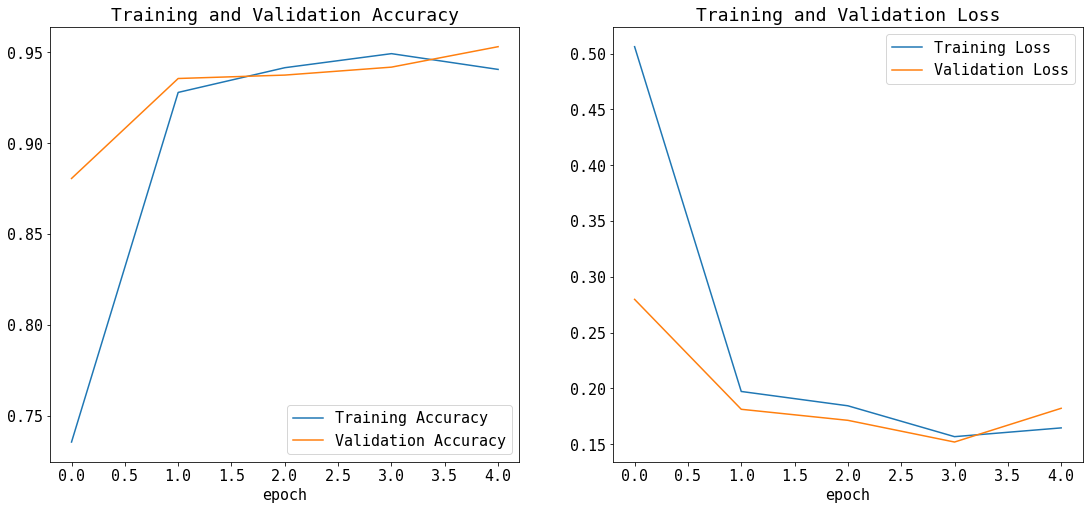

In [31]:
stats(history, 5, "convnet.png")

In [78]:
matrix = test_stats(test_datagen, model, 87) #Tomara mucho tiempo

87/87 [==============================] - 10s 111ms/step
2756
Accuracy: 0.935776
Precision: 0.976209
Recall: 0.893324
F1 score: 0.932929


In [79]:
matrix

array([[1348,   30],
       [ 147, 1231]])

<Figure size 720x504 with 0 Axes>

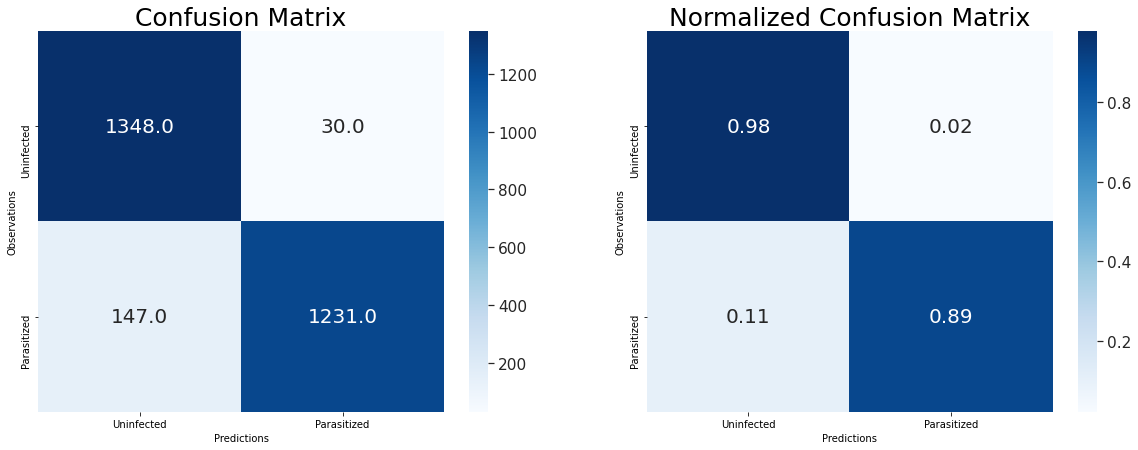

In [80]:
confusionMatrix(matrix, "matrix_convnet.png")

# Transfer Learning

In [0]:
#Generators for Transfer Learning Models
train_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
#IMAGE_SIZE for each model
IMAGE_SIZE_RESNET =(224, 224)
IMAGE_SIZE_INCEPTION =(299, 299)
IMAGE_SIZE_EFFICIENT =(456, 456) #(300,300)

## Inception Classification

In [0]:
#Import Inception from the hub
classification_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"

In [0]:
classification_head = hub.KerasLayer(classification_url,input_shape=IMAGE_SIZE_INCEPTION+(3,))

In [0]:
classification_head.trainable = False

In [41]:
#Prepage generators from directories
train_datagen_Inception = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_INCEPTION,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
val_datagen_Inception = val_image_generator.flow_from_directory(validation_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_INCEPTION,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
test_datagen_Inception = test_image_generator.flow_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_INCEPTION,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])

Found 19842 images belonging to 2 classes.
Found 4960 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
model_class = Sequential([
  classification_head,
  tf.keras.layers.Flatten(),
  #This might be wrong
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [180]:
model_class.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              55875273  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1026048   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 56,902,346
Trainable params: 1,027,073
Non-trainable params: 55,875,273
_________________________________________________________________


In [0]:
model_class.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
history = model_class.fit(
    train_datagen_Inception,
    epochs=2,
    steps_per_epoch=50,#How many batches to use in training
    validation_steps = 10, #How many batches to use in evaluation
    validation_data=val_datagen_Inception
)

Epoch 1/2
50/50 [==============================] - 862s 17s/step - loss: 0.7214 - accuracy: 0.7956 - val_loss: 0.2726 - val_accuracy: 0.9000
Epoch 2/2
50/50 [==============================] - 857s 17s/step - loss: 0.2781 - accuracy: 0.8913 - val_loss: 0.2075 - val_accuracy: 0.9062


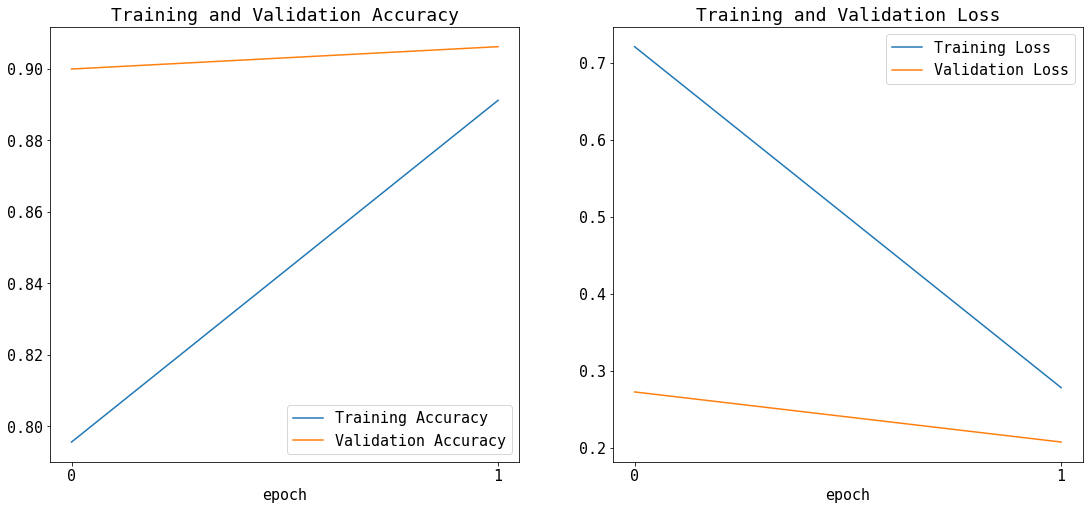

In [98]:
stats(history, 2, "INCEPTION_CLASS.png")

In [99]:
matrix = test_stats(test_datagen_Inception, model_class, 87) #Tomara mucho tiempo

87/87 [==============================] - 1240s 14s/step
2756
Accuracy: 0.918723
Precision: 0.919942
Recall: 0.917271
F1 score: 0.918605


In [100]:
matrix

array([[1268,  110],
       [ 114, 1264]])

<Figure size 720x504 with 0 Axes>

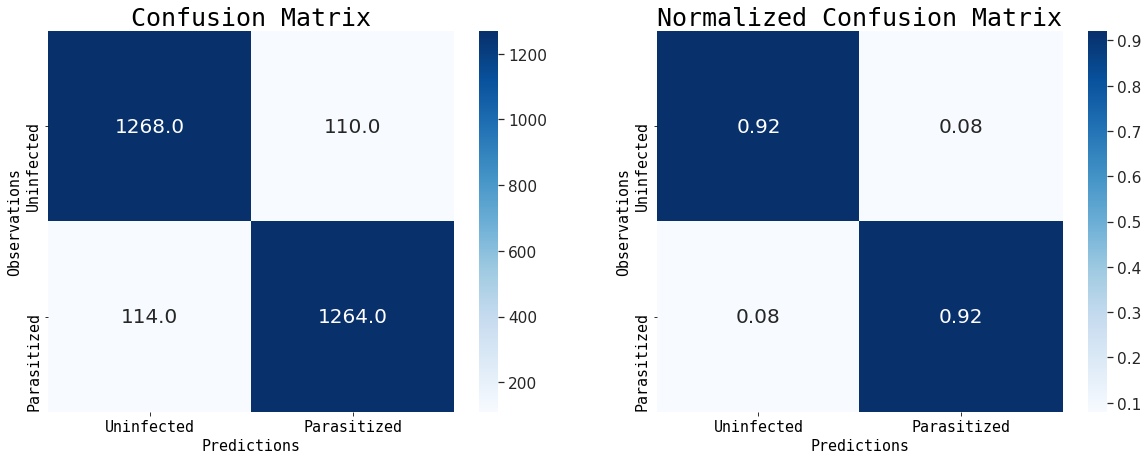

In [101]:
confusionMatrix(matrix, "matrix_inception.png")

## EfficientNet

In [17]:
#Generators from efficientNet
train_datagen_EFFICIENT = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=64,
                                                           target_size=IMAGE_SIZE_EFFICIENT,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
val_datagen_EFFICIENT = val_image_generator.flow_from_directory(validation_dir,
                                                           shuffle=True,
                                                           batch_size=64,
                                                           target_size=IMAGE_SIZE_EFFICIENT,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
test_datagen_EFFICIENT = test_image_generator.flow_from_directory(test_dir,
                                                           batch_size=64,
                                                           shuffle=False,
                                                           target_size=IMAGE_SIZE_EFFICIENT,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])

Found 19842 images belonging to 2 classes.
Found 4960 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [0]:
classification_url = "https://tfhub.dev/google/efficientnet/b3/classification/1"

In [0]:
classification_head = hub.KerasLayer(classification_url,input_shape=IMAGE_SIZE_EFFICIENT+(3,))

In [0]:
classification_head.trainable = False

In [0]:
model_ef = Sequential([
  classification_head,
  tf.keras.layers.Flatten(),
  #This might be wrong
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [0]:
model_ef.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model_ef.fit(
    train_datagen_EFFICIENT,
    epochs=5,
    steps_per_epoch=20,
    validation_steps = 10,
    validation_data=val_datagen_EFFICIENT
)

Epoch 1/5
20/20 [==============================] - 431s 22s/step - loss: 0.8431 - accuracy: 0.7328 - val_loss: 0.3236 - val_accuracy: 0.8984
Epoch 2/5
20/20 [==============================] - 416s 21s/step - loss: 0.2755 - accuracy: 0.9062 - val_loss: 0.2104 - val_accuracy: 0.9141
Epoch 3/5
20/20 [==============================] - 391s 20s/step - loss: 0.2552 - accuracy: 0.9102 - val_loss: 0.1814 - val_accuracy: 0.9344
Epoch 4/5
20/20 [==============================] - 391s 20s/step - loss: 0.2114 - accuracy: 0.9258 - val_loss: 0.1725 - val_accuracy: 0.9375
Epoch 5/5
20/20 [==============================] - 384s 19s/step - loss: 0.1907 - accuracy: 0.9258 - val_loss: 0.2017 - val_accuracy: 0.9250


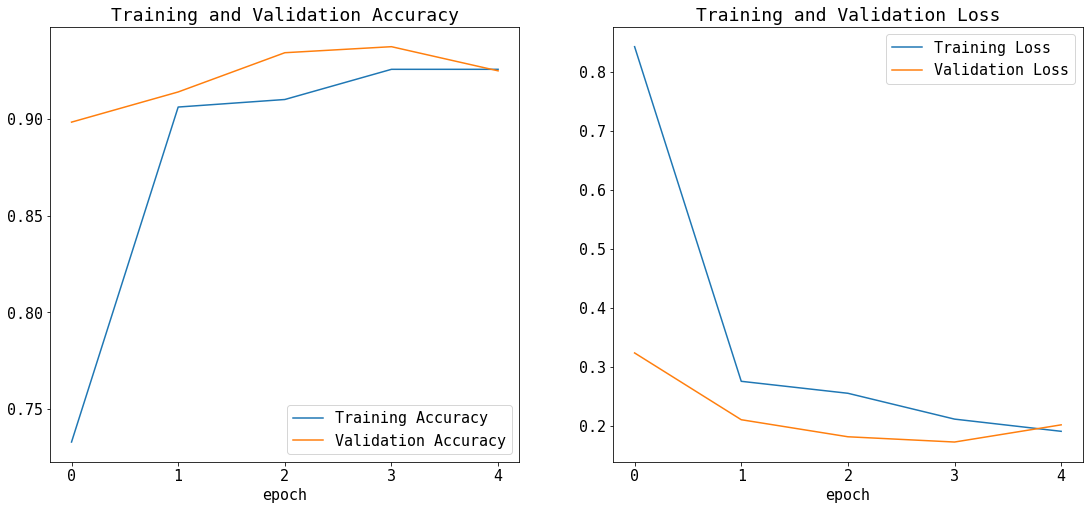

In [24]:
stats(history, 5, "Efficient_net.png")

In [26]:
matrix = test_stats(test_datagen_EFFICIENT, model_ef, int(math.ceil(test_datagen_EFFICIENT.n/test_datagen_EFFICIENT.batch_size)))

44/44 [==============================] - 564s 13s/step
2756
Accuracy: 0.935051
Precision: 0.930985
Recall: 0.939768
F1 score: 0.935356


In [27]:
matrix

array([[1282,   96],
       [  83, 1295]])

<Figure size 720x504 with 0 Axes>

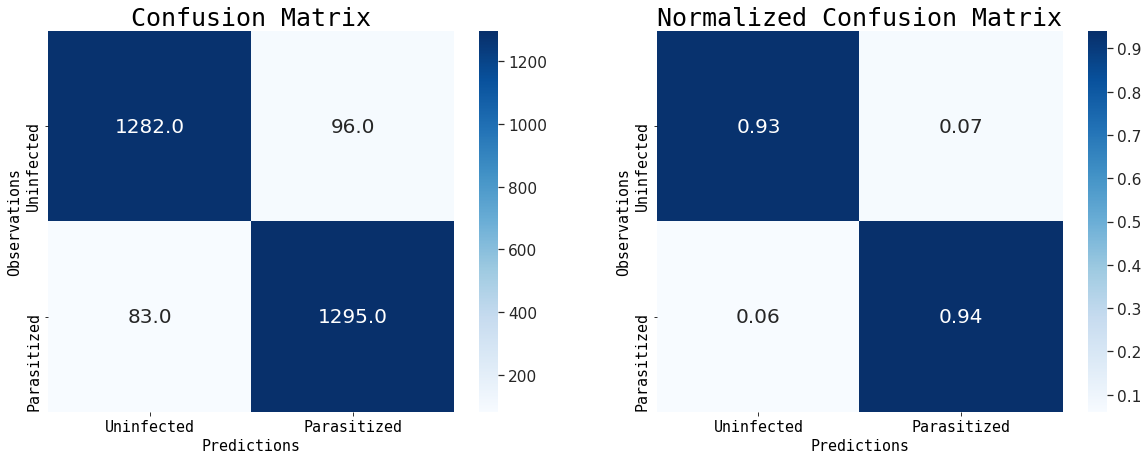

In [28]:
confusionMatrix(matrix, "matrix_efficient.png")

## ResNET

In [29]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_RESNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
val_data_gen = val_image_generator.flow_from_directory(validation_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_RESNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_RESNET,
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])

Found 19842 images belonging to 2 classes.
Found 4960 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


### Application Base Model


In [30]:
base_model = ResNet50V2(input_shape=IMAGE_SIZE_RESNET+(3,),
                                               include_top=False,
                                               weights='imagenet')

94674944/94668760 [==============================] - 1s 0us/step


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

In [33]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_steps = 5,
    validation_data=val_data_gen
)

Epoch 1/5
5/5 [==============================] - 14s 3s/step - loss: 0.6542 - accuracy: 0.7125 - val_loss: 0.5130 - val_accuracy: 0.8500
Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 0.6059 - accuracy: 0.7688 - val_loss: 0.5136 - val_accuracy: 0.8562
Epoch 3/5
5/5 [==============================] - 13s 3s/step - loss: 0.3204 - accuracy: 0.8750 - val_loss: 0.4157 - val_accuracy: 0.8687
Epoch 4/5
5/5 [==============================] - 13s 3s/step - loss: 0.3719 - accuracy: 0.8500 - val_loss: 0.2172 - val_accuracy: 0.9062
Epoch 5/5
5/5 [==============================] - 13s 3s/step - loss: 0.2385 - accuracy: 0.8938 - val_loss: 0.4546 - val_accuracy: 0.8562


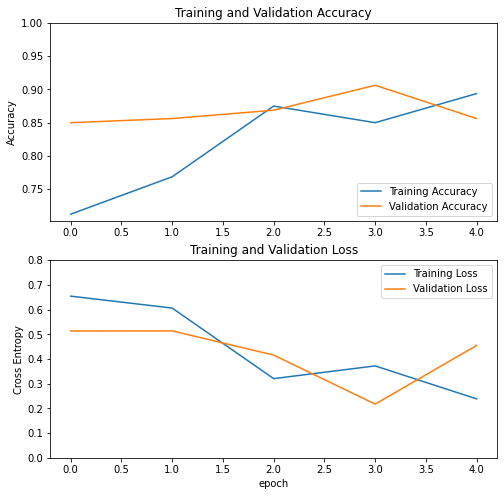

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

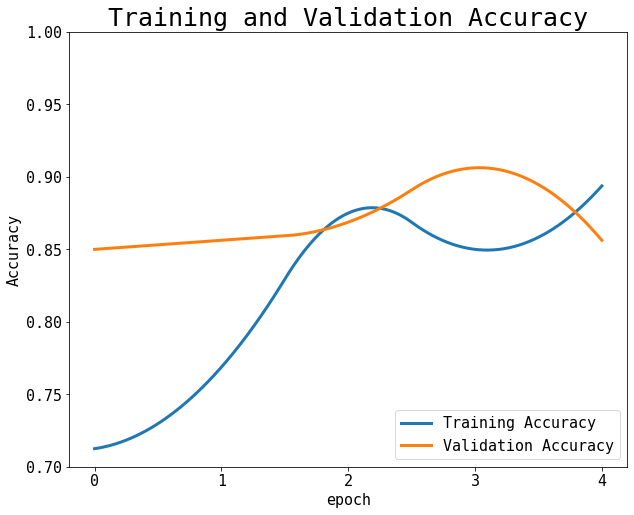

In [55]:
### Smoothing Accuracy
hist = history.history
acc = hist['accuracy']
val_acc = hist['val_accuracy']
smoothing(acc, val_acc, np.arange(5), "Accuracy", [0.7, 1], "resnet_accuracy.png",'Training and Validation Accuracy',
           'Training Accuracy', "Validation Accuracy", \
          'lower right')

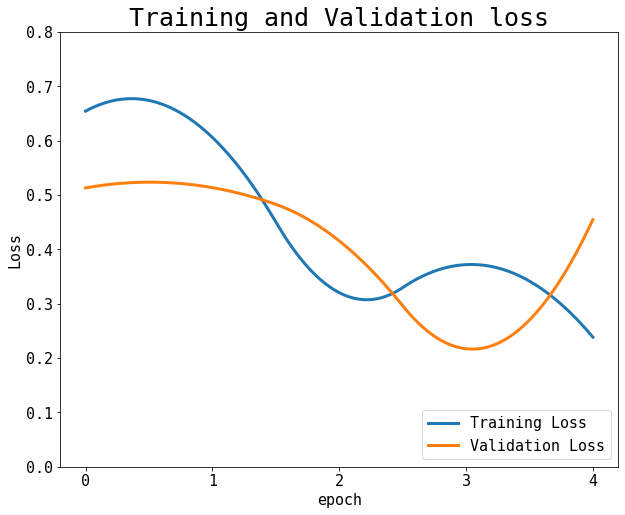

In [56]:
### Smoothing Loss
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
smoothing(loss, val_loss, np.arange(5), "Loss",[0,0.8], "resnet_loss.png", 'Training and Validation loss',
          'Training Loss', "Validation Loss", \
          'lower right')

In [0]:
class_names = ["Uninfected", "Parasitized"]

In [40]:
images_data_generator = train_image_generator.flow_from_directory(path_images,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE_RESNET,
                                                           class_mode='binary', classes= ["Uninfected", "Parasitized"])

Found 27558 images belonging to 2 classes.


In [0]:
image_batch, labels_batch = next(images_data_generator)

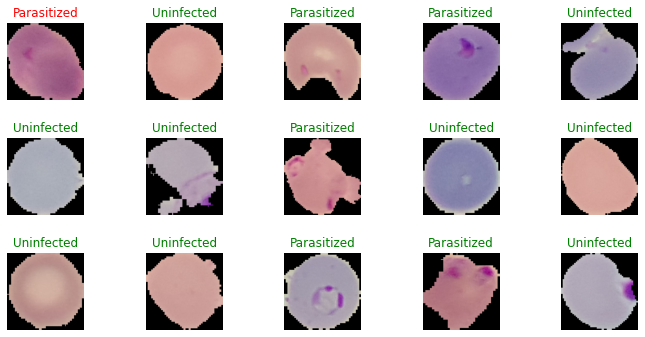

In [45]:
#Getting the model to predict
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

In [57]:
STEP_SIZE = int(math.ceil(test_data_gen.n/test_data_gen.batch_size))
matrix = test_stats(test_data_gen, model,STEP_SIZE)

87/87 [==============================] - 118s 1s/step
2756
Accuracy: 0.878810
Precision: 0.957895
Recall: 0.792453
F1 score: 0.867355


In [58]:
matrix

array([[1330,   48],
       [ 286, 1092]])

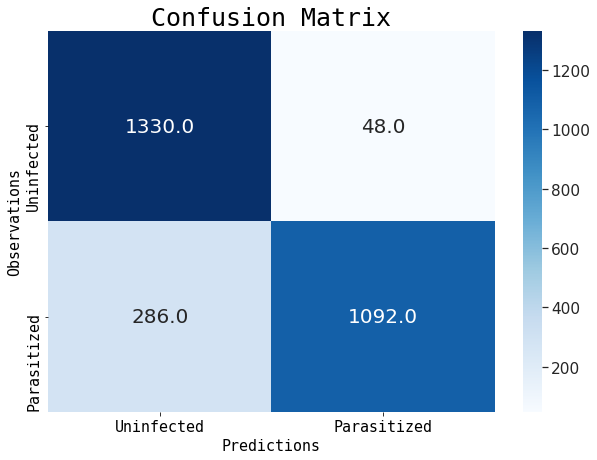

In [59]:
confusionMatrix_separated(matrix, "resnet_matrix.png", False)

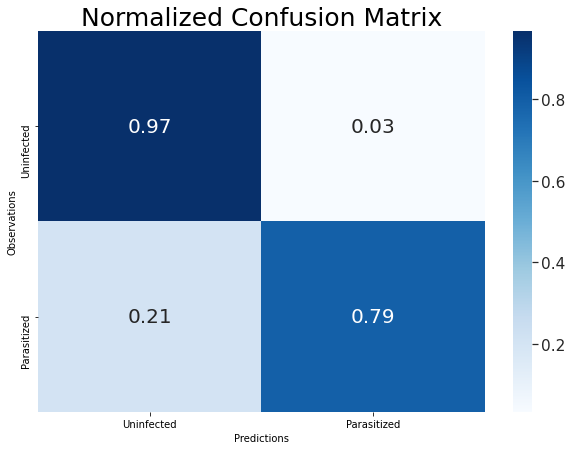

In [60]:
confusionMatrix_separated(matrix, "resnet_matrix.png", True)

### Fine tuning


In [0]:
base_model.trainable = True

In [62]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  190


In [63]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 16,542,721
Non-trainable params: 9,121,280
_________________________________________________________________


In [64]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=5,
                         initial_epoch =  history.epoch[-1],
                         validation_steps = 5,
                         validation_data=val_data_gen)

Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 0.3336 - accuracy: 0.8562 - val_loss: 2.6554 - val_accuracy: 0.8188
Epoch 6/10
5/5 [==============================] - 17s 3s/step - loss: 0.5577 - accuracy: 0.8687 - val_loss: 1.2681 - val_accuracy: 0.8813
Epoch 7/10
5/5 [==============================] - 17s 3s/step - loss: 0.2454 - accuracy: 0.9125 - val_loss: 76.8514 - val_accuracy: 0.4563
Epoch 8/10
5/5 [==============================] - 17s 3s/step - loss: 0.2911 - accuracy: 0.9187 - val_loss: 70.1195 - val_accuracy: 0.5437
Epoch 9/10
5/5 [==============================] - 16s 3s/step - loss: 0.2625 - accuracy: 0.9438 - val_loss: 2.3303 - val_accuracy: 0.8313
Epoch 10/10
5/5 [==============================] - 17s 3s/step - loss: 0.2619 - accuracy: 0.9187 - val_loss: 28.5801 - val_accuracy: 0.5312


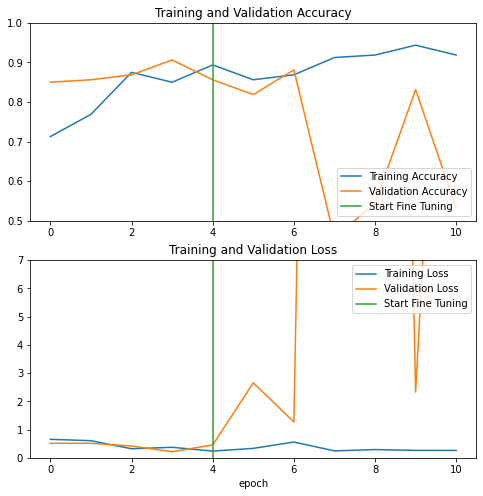

In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 7.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

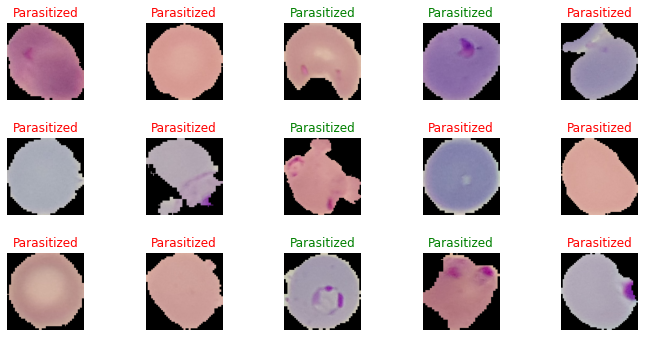

In [66]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

In [67]:
STEP_SIZE = int(math.ceil(test_data_gen.n/test_data_gen.batch_size))
matrix = test_stats(test_data_gen, model,STEP_SIZE)

87/87 [==============================] - 124s 1s/step
2756
Accuracy: 0.539913
Precision: 0.520786
Recall: 1.000000
F1 score: 0.684891


In [68]:
matrix

array([[ 110, 1268],
       [   0, 1378]])

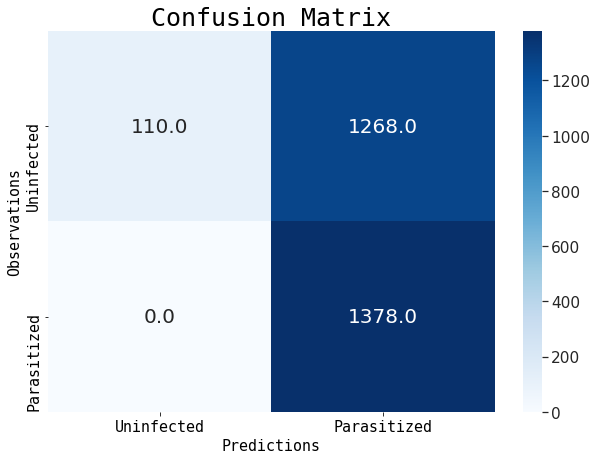

In [75]:
confusionMatrix_separated(matrix, "resnet_matrix.png", False)

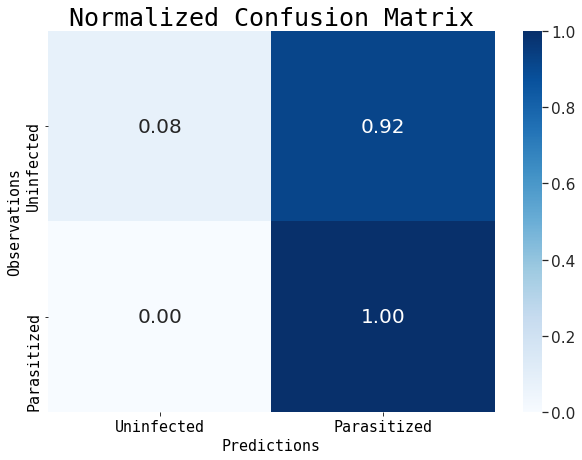

In [74]:
confusionMatrix_separated(matrix, "norm_resnet_matrix.png", True)

# Test Previously Saved Models

In [0]:
#Paths to load models from
# path_conv = "/content/drive/My Drive/IO/Malaria/models/Convnet/model.h5"
# path_inception = "/content/drive/My Drive/IO/Malaria/models/Inception/model.h5"
# path_efficient = "/content/drive/My Drive/IO/Malaria/models/EfficientNet/model.h5"
# path_resnet = "/content/drive/My Drive/IO/Malaria/models/ResNet/model.h5"
path_conv = "convnet.h5"
path_inception = "inception.h5"
path_efficient = "efficient.h5"
path_resnet = "resnet.h5"

In [0]:
keras_layer = hub.KerasLayer

In [0]:
keras_layer.trainable = False

In [0]:
convnet = tf.keras.models.load_model(path_conv)
inception = tf.keras.models.load_model(path_inception, custom_objects={'KerasLayer':keras_layer})
efficient = tf.keras.models.load_model(path_efficient,  custom_objects={'KerasLayer':keras_layer})
resnet = tf.keras.models.load_model(path_resnet)

## Test

In [0]:
#Test a model, 
# options any from [CONVENT, RESNET, INCEPTION, EFFICIENT]
def test(model, option, filename='matrix.png'):
  if(option == 'CONVNET'):
    test_image_generator = ImageDataGenerator(rescale=1./255, samplewise_std_normalization=True)
  else:
    test_image_generator = ImageDataGenerator(rescale=1./255)
  dict_ = {"RESNET": IMAGE_SIZE_RESNET ,"EFFICIENT": IMAGE_SIZE_EFFICIENT, "CONVNET": IMAGE_SIZE_CONVNET, "INCEPTION": IMAGE_SIZE_INCEPTION}
  test = test_image_generator.flow_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=32,
                                                           target_size=dict_.get(option, IMAGE_SIZE_CONVNET),
                                                           class_mode='binary',  classes= ["Uninfected", "Parasitized"])
  STEP_SIZE_TEST= int(math.ceil(test.n/test.batch_size))
  matrix = test_stats(test, model, STEP_SIZE_TEST)
  confusionMatrix(matrix, filename)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2756 images belonging to 2 classes.
87/87 [==============================] - 10s 116ms/step
2756
Accuracy: 0.943759
Precision: 0.964313
Recall: 0.921626
F1 score: 0.942486


<Figure size 720x504 with 0 Axes>

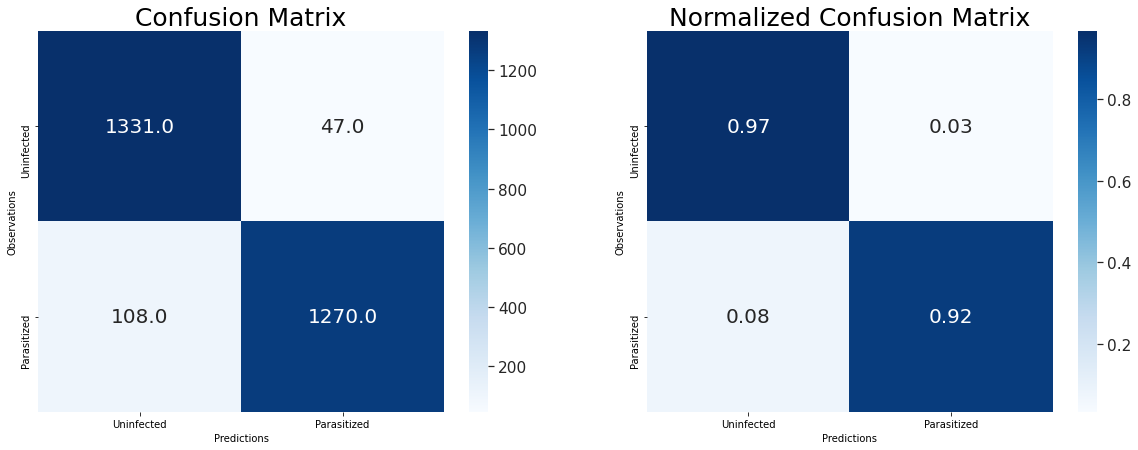

In [152]:
test(convnet, "CONVNET")

Found 2756 images belonging to 2 classes.
87/87 [==============================] - 1289s 15s/step
2756
Accuracy: 0.918723
Precision: 0.919942
Recall: 0.917271
F1 score: 0.918605


<Figure size 720x504 with 0 Axes>

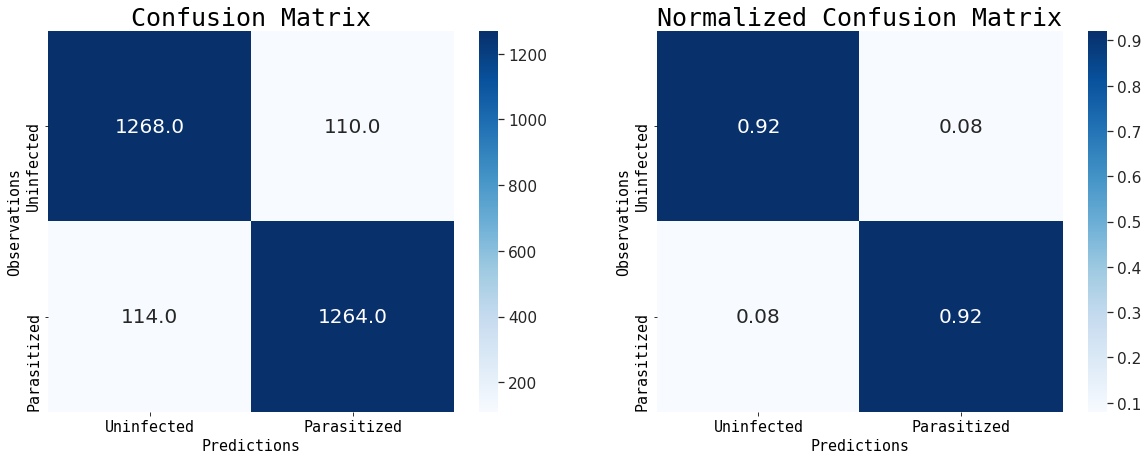

In [226]:
test(inception, "INCEPTION")

Found 2756 images belonging to 2 classes.
87/87 [==============================] - 1374s 16s/step
2756
Accuracy: 0.936502
Precision: 0.930565
Recall: 0.943396
F1 score: 0.936937


<Figure size 720x504 with 0 Axes>

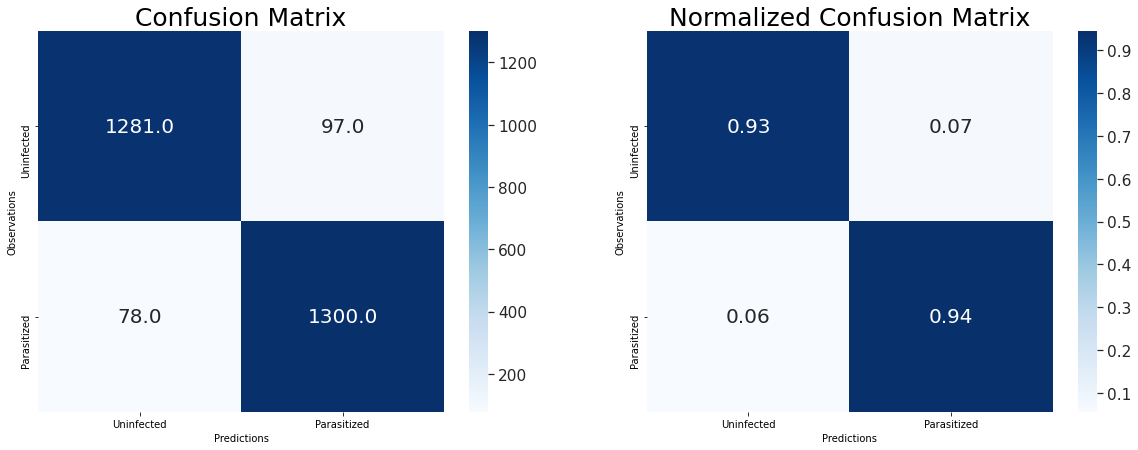

In [154]:
test(efficient, "EFFICIENT")

Found 2756 images belonging to 2 classes.
87/87 [==============================] - 361s 4s/step
2756
Accuracy: 0.894412
Precision: 0.849518
Recall: 0.958636
F1 score: 0.900784


<Figure size 720x504 with 0 Axes>

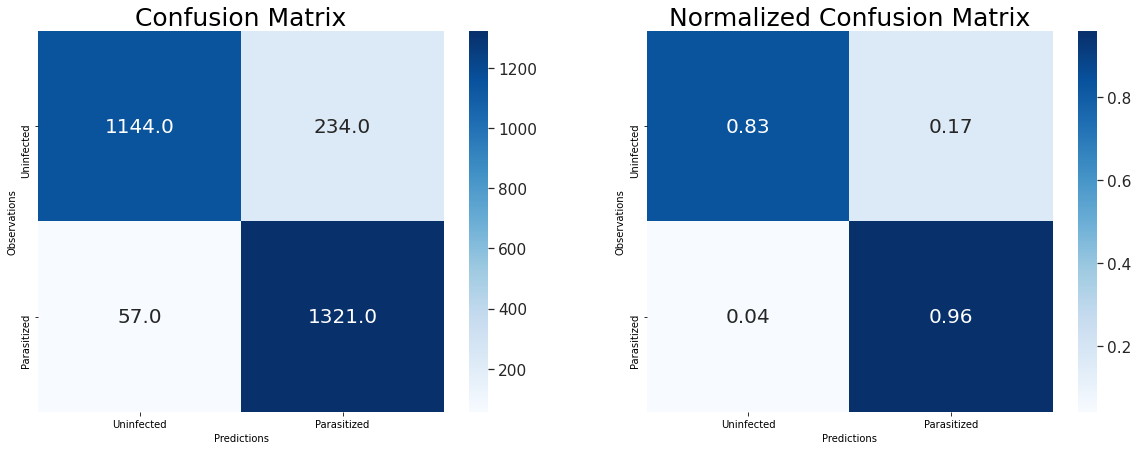

In [156]:
test(resnet, "RESNET")